In [1]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2025-03-06 11:49:41.958971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741261781.970147    2276 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741261781.973354    2276 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 11:49:41.984865: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("TensorFlow version:", tf.__version__)
print("Detected devices:", tf.config.list_physical_devices())
assert tf.test.is_built_with_cuda() 

TensorFlow version: 2.18.0
Detected devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

# ? CNNs are the key topic of Week 6.
# * See W6 Lecture. It does quite a good job of explaining them.
# * W6 has animated slides, make sure editing is enabled to see them.
class LeNetwork:
    # ? Static methods, like in Java, can be directly called without instantiating
    # ? an object of the class.
    @staticmethod
    def build(input_shape, classes, kernel_size, pool_size, strides, activation):
        model = Sequential()

        # ? Padding adds 1s or 0s to increase the original image size to get the
        # ? desired size. "Valid" is output < input. "Same" is output == input.
        # ? With same, the area around the input is padded with zeroes.
        model.add(Conv2D(20, kernel_size = kernel_size, padding = "same",
        # * Input_shape is only mandatory on this one because it's the first layer.
                         input_shape = input_shape))
        model.add(Activation(activation))

        # ? See W6 lecture. The "pool" of pixels used to make the convoluted feature.
        # ? This grabs 2x2 pixel clusters, then moves 2x2 across until the image is mapped.
        model.add(MaxPooling2D(pool_size = pool_size, strides = strides))

        # ? Max pooling selects the highest (max) value in the group.
        # ? Average pooling would instead average them all.

        model.add(Conv2D(50, kernel_size = kernel_size, padding = "same"))
        model.add(Activation(activation))
        model.add(MaxPooling2D(pool_size = pool_size, strides = strides))

        # ? Flattening the 2-dimensional output of the max pooling layer
        # ? so that dense layers can read it. Dense layers only accept one dimension.
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation(activation))

        # Classification layer, using softmax.
        # Dense layer using amount of classes where the maximum weight = prediction.
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        # ? Multi-classification = softmax.
        # ? Binary classification = sigmoid.

        return model

In [4]:
NB_EPOCH = 20
BATCH_SIZE = 128
VERBOSE = 1
VALIDATION_SPLIT=0.2
# Input image dimensions
IMG_ROWS, IMG_COLS = 28, 28
# Number of class labels or outputs
NB_CLASSES = 10
#INPUT_SHAPE = (1, IMG_ROWS, IMG_COLS) # ? Not sure why this is here.
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 1)

An extra dimension is added to the image to represent **colour** (channels). Only one dimension is added because MNIST is a set of greyscale images. Convolution layers need a dimension representing the channels. RGB images have 3 channels, greyscale have 1. The channels go from 1 to 255 for colour value, but that needs to be reduced to be between 0 and 1 so it's divided by 255 before being input.

In [5]:
# Split data as train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('Shape of x_train ',X_train.shape, ' with dtype of ',
X_train.dtype)
print('Shape of x_test ',X_test.shape, ' with dtype of ', X_test.dtype)
print('Shape of y_train ',y_train.shape, ' with dtype of ',
y_train.dtype)
print('Shape of y_test ',y_test.shape, ' with dtype of ', y_test.dtype)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('Shape of X_train after adding one extra dim',X_train.shape)

# Convert class vectors to binary class matrices using one-hot encoding method
y_train = to_categorical(y_train, NB_CLASSES)
y_test = to_categorical(y_test, NB_CLASSES)
print('One Sample from y_train after one hot encoding ', y_train[0])

Shape of x_train  (60000, 28, 28)  with dtype of  uint8
Shape of x_test  (10000, 28, 28)  with dtype of  uint8
Shape of y_train  (60000,)  with dtype of  uint8
Shape of y_test  (10000,)  with dtype of  uint8
60000 train samples
10000 test samples
Shape of X_train after adding one extra dim (60000, 28, 28, 1)
One Sample from y_train after one hot encoding  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [6]:
KERNEL_SIZE = 5
POOL_SIZE = (2, 2)
STRIDES = (2, 2)
ACTIVATION = "relu"
LR = 0.01
OPTIMIZER = Adam(learning_rate = LR)

model = LeNetwork.build(INPUT_SHAPE, NB_CLASSES, KERNEL_SIZE, POOL_SIZE, STRIDES, ACTIVATION)

model.compile(loss = "categorical_crossentropy",
              optimizer = OPTIMIZER,
              metrics = ["accuracy"])

I0000 00:00:1741261800.389764    2276 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Finding the best amount of epochs is known as early stopping.

You considered it during Week 5. It's best to use enough epochs to minimise training loss but reduce them when validation loss starts going up.

In [7]:

# ! You've now reached the point where the laptop won't cut it anymore.
# ! Training this model heats the laptop to 94 degrees and is slow.
history = model.fit(X_train, y_train,
                    batch_size = BATCH_SIZE,
                    epochs = NB_EPOCH,
                    verbose = VERBOSE,
                    validation_split = VALIDATION_SPLIT)

Epoch 1/20


I0000 00:00:1741261806.910575    2372 service.cc:148] XLA service 0x7f9a7c002950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741261806.910608    2372 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-03-06 11:50:06.928907: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741261807.050382    2372 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-06 11:50:07.796277: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_260', 188 bytes spill stores, 188 bytes spill loads



 73/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3589 - loss: 2.0649

I0000 00:00:1741261810.085012    2372 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


370/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7334 - loss: 0.8443

2025-03-06 11:50:12.299100: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 192 bytes spill stores, 192 bytes spill loads



375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7361 - loss: 0.8374 - val_accuracy: 0.9762 - val_loss: 0.0788
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9781 - loss: 0.0702 - val_accuracy: 0.9728 - val_loss: 0.0889
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9811 - loss: 0.0601 - val_accuracy: 0.9768 - val_loss: 0.0820
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - accuracy: 0.9853 - loss: 0.0455 - val_accuracy: 0.9822 - val_loss: 0.0606
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9880 - loss: 0.0395 - val_accuracy: 0.9802 - val_loss: 0.0679
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9882 - loss: 0.0381 - val_accuracy: 0.9798 - val_loss: 0.0796
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9892 - loss: 0.0379 - val_accuracy: 0.9737 - val_loss: 0.1085
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9885 - loss: 0.0379 - val_accuracy: 0.9762 - va

In [8]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Test score: 0.10096371918916702
Test accuracy: 0.9858999848365784


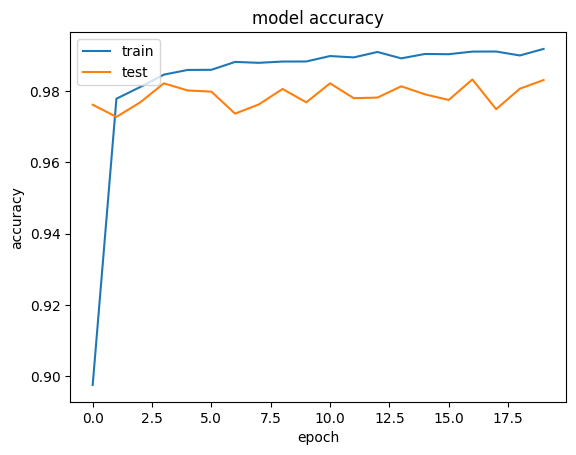

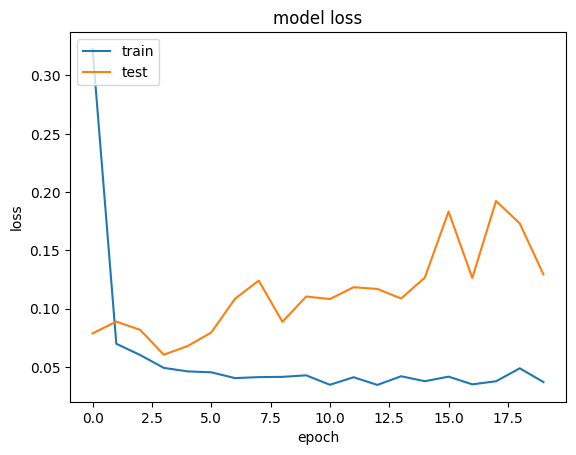

In [9]:
# summarise history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarise history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()